In [3]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 12, 31)

## Step 2

Let us take the example of the oil ETF time series that we collected back in GWP1 to illustrate bull, bear and stagnant regimes.

In [7]:
#redownloading the Oil ETF time series
oil_etf = yf.download('USO', start=start, end=end)['Close']

C:\Users\susha\AppData\Local\Temp\ipykernel_126780\162597237.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_etf = yf.download('USO', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed


let us now plot this time series

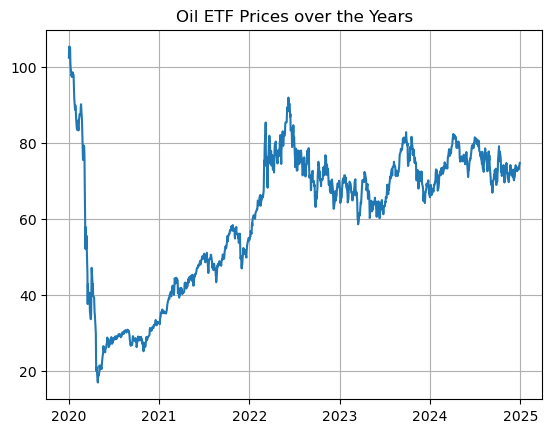

In [12]:
plt.plot(oil_etf)
plt.title("Oil ETF Prices over the Years")
plt.grid()

Now, let us zoom in some time periods of this time series to illustrate different regimes.

First, the bull regime is shown.

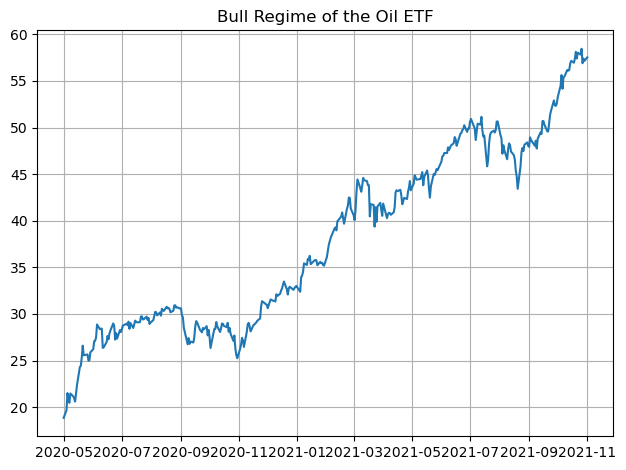

In [35]:
plt.plot(oil_etf['2020-05-01':'2021-11-01']) #1st May 2020 to 1st November 2021
plt.title("Bull Regime of the Oil ETF")
plt.grid()
plt.tight_layout()

Now, let us visualize a stagnant regime.

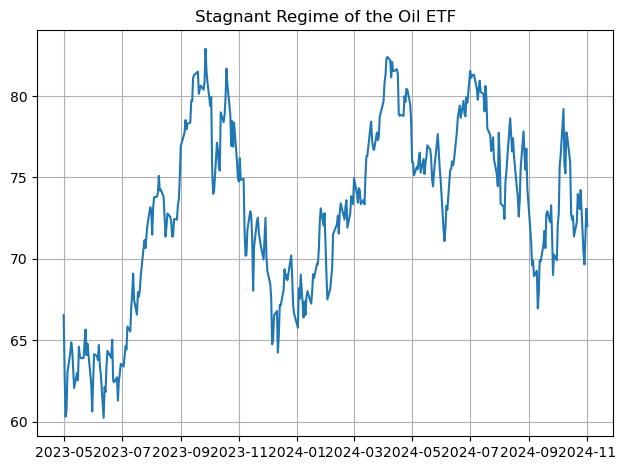

In [37]:
plt.plot(oil_etf['2023-05-01':'2024-11-01']) #1st May 2023 to 1st November 2024
plt.title("Stagnant Regime of the Oil ETF")
plt.grid()
plt.tight_layout()

Let us now visualize a bear regime.

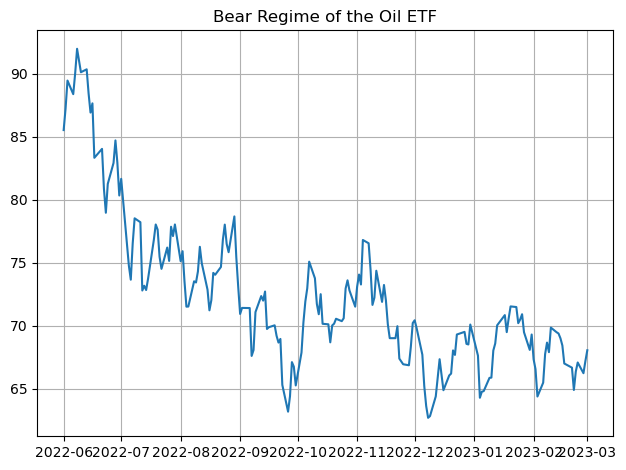

In [50]:
plt.plot(oil_etf['2022-06-01':'2023-03-01']) #1st June 2022 to 1st March 2023
plt.title("Bear Regime of the Oil ETF")
plt.grid()
plt.tight_layout()